In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch import optim
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from collections import OrderedDict

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.layers import LaterallyConnectedLayer, LaterallyConnectedLayer2
from lateral_connections.torch_utils import *

import wandb
import datetime

DO_WANDB = True

In [3]:
config = {
    'num_classes': 10,
    'learning_rate': 3e-3,
    'num_multiplex': 3,
    'batch_size': 10,
    'num_epochs': 5,
    'lcl_alpha': 3e-3,
    'lcl_eta': 0.05,
    'lcl_theta': 0.2,
    'lcl_iota': 0.2,
    'lcl_distance': 2,
    'conv_size': 8,
    'num_noisy_iterations': 500
}

In [4]:
base_name = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
wandb_run_name = base_name
wandb_group_name = 'TinyLCL_Debug'

wandb.login(key='efd0a05b7bd26ed445bf073625a373b845fc9385')
wandb.init(
    project='MT_LateralConnections',
    entity='lehl',
    #group=wandb_group_name,
    group='debug',
    name=wandb_run_name,
    config=config,
    mode='disabled'
)

wandb: Currently logged in as: lehl (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/claude/.netrc


In [5]:
def plot_kernels(model, plot_scale=3):
    
    if type(model.lcl) == LaterallyConnectedLayer:
        kernel_data = model.lcl.K.cpu()
    else:
        kernel_data = model.lcl._kernel_to_compact(model.lcl.K.cpu())
            
    num_kernels = kernel_data.shape[0]
    
    fig, axs = plt.subplots(num_kernels, num_kernels, figsize=(plot_scale*num_kernels, plot_scale*num_kernels))

    for x in tqdm(range(num_kernels)):
        for y in range(num_kernels):
            axs[x,y].imshow(kernel_data[x,y,...])
            
    plt.show()
    plt.close()

class TinyLateralNetwork(nn.Module):
    def __init__(self, config):
        super(TinyLateralNetwork, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.config = config
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=config['conv_size'], padding=1, kernel_size=(3,3))
        self.relu1 = nn.Sigmoid()
        self.maxpool = nn.AdaptiveMaxPool2d((14, 14))
        self.lcl = LaterallyConnectedLayer(self.config['num_multiplex'], config['conv_size'], 14, 14,
                              d=self.config['lcl_distance'],
                              prd=self.config['lcl_distance'],
                              disabled=False,
                              alpha=self.config['lcl_alpha'],
                              eta=self.config['lcl_eta'],
                              theta=self.config['lcl_theta'],
                              iota=self.config['lcl_iota'],
                              use_scaling=False,
                              random_k_change=False,
                              random_multiplex_selection=False,
                              gradient_learn_k=False,
                              num_noisy_iterations=config['num_noisy_iterations'])
        
        self.fc1 = nn.Linear(in_features=config['conv_size']*14*14, out_features=100)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=100, out_features=self.config['num_classes'])
        
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=self.config['learning_rate'], momentum=0.9, weight_decay=0.0005)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool(x)
        x = self.lcl(x)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        
        return x
    
    def train_with_loader(self, train_loader, val_loader, test_loader=None, num_epochs=5):
        total_params = sum(p.numel() for p in self.parameters())
        print(f"[INFO]: {total_params:,} total parameters.")
        total_trainable_params = sum(
            p.numel() for p in self.parameters() if p.requires_grad)
        print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

        self.train()
        for epoch in range(num_epochs):
            print(f"[INFO]: Epoch {epoch} of {num_epochs}")
        
            correct = 0
            total = 0
            total_loss = 0
            counter = 0

            agg_correct = 0
            agg_total = 0
            agg_loss = 0

            # Training Loop
            for i, (images, labels) in tqdm(enumerate(train_loader, 0), total=len(train_loader), desc='Training'):
                counter += 1
                
                images = images.to(self.device)
                labels = labels.to(self.device)

                outputs = self(images)
                loss = self.loss_fn(outputs, labels)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                _, preds = torch.max(outputs, 1)
        
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                total_loss += (loss.item() / labels.size(0))

                current_iteration = epoch*len(train_loader) + i

                if current_iteration > 0 and (current_iteration % 1250) == 0:
                    #self.save(f"models/vgg_with_lcl/{self.run_identifier}__it{current_iteration}_e{epoch}.pt")
                    val_acc, val_loss = self.test(val_loader)
                    #self.train()
                    log_dict = { 'val_loss': val_loss, 'val_acc': val_acc, 'iteration': current_iteration }

                    if test_loader:
                        test_acc, test_loss = self.test(test_loader)
                        log_dict['test_acc'] = test_acc
                        log_dict['test_loss'] = test_loss

                    print(log_dict)
                    wandb.log(log_dict, commit=False)

                if (current_iteration % 250) == 0:
                    print({ 'train_batch_loss': round(total_loss/250,4), 'train_batch_acc': round(correct/total,4), 'iteration': current_iteration })
                    wandb.log({ 'train_batch_loss': round(total_loss/250,4), 'train_batch_acc': round(correct/total,4), 'iteration': current_iteration })
                    
                    agg_correct += correct
                    agg_total += total
                    agg_loss += total_loss

                    correct = 0
                    total = 0
                    total_loss = 0
                    counter = 0
            
            print({'epoch': epoch, 'iteration': current_iteration, 'train_loss': agg_loss/len(train_loader), 'train_acc': agg_correct/agg_total})
            plot_kernels(self)
            wandb.log({'epoch': epoch, 'iteration': current_iteration, 'train_loss': agg_loss/len(train_loader), 'train_acc': agg_correct/agg_total})
            
    def test(self, test_loader):
        self.eval()

        correct = 0
        total = 0
        total_loss = 0
        counter = 0

        # Evaluation Loop
        for i, (images, labels) in tqdm(enumerate(test_loader, 0), total=len(test_loader), desc='Testing', leave=False):
            counter += 1
            images = images.to(self.device)
            labels = labels.to(self.device)

            outputs = self(images)
            loss = self.loss_fn(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
    
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += (loss.item() / labels.size(0))

        total_loss /= counter
        acc = correct / total

        return acc, total_loss

In [6]:
model = TinyLateralNetwork(config)
model.to(model.device)

TinyLateralNetwork(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): Sigmoid()
  (maxpool): AdaptiveMaxPool2d(output_size=(14, 14))
  (lcl): LaterallyConnectedLayer(3, (8, 14, 14), d=2, disabled=False, update=True)
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [7]:
def small_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5))
    ])

dataset = MNIST('images/mnist/', train=True, transform=small_transform(), download=True)

train_size = 50000
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = torch.utils.data.random_split(dataset, [train_size, eval_size], generator=torch.Generator().manual_seed(42))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=1)

corrupt_dataset = load_mnistc('line')

corrupt_loader = torch.utils.data.DataLoader(corrupt_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=1)

## Adversarial Example

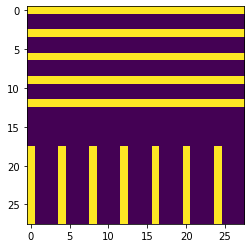

In [8]:
imgs, lbls = next(iter(train_loader))

imgs.shape, lbls.shape

labels = torch.arange(10)

images = torch.zeros((10, 1, 28, 28))
images[:, 0,0:14:3,:] = 1
images[:, 0,-10:,0::4] = 1

plt.imshow(images[0,0])

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


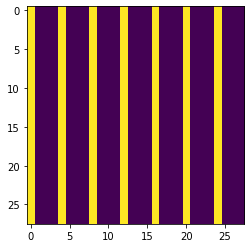

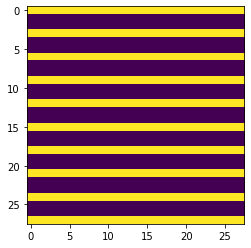

In [9]:
images = torch.zeros((10, 1, 28, 28))
images[:5, 0, :, 0::4] = 1.
images[5:, 0, 0::3, :] = 1.

labels = torch.LongTensor([0,0,0,0,0,1,1,1,1,1])
print(labels)

plt.imshow(images[0, 0])
plt.show()
plt.imshow(images[9, 0])

In [10]:
images_A = images[:5].repeat(2, 1, 1, 1)
images_B = images[5:].repeat(2, 1, 1, 1)

labels_A = labels[:5].repeat(2)
labels_B = labels[5:].repeat(2)

labels_A, labels_B

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

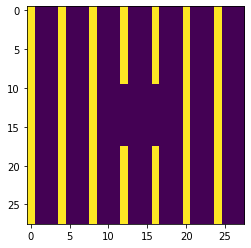

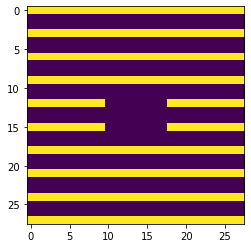

In [11]:
images_test = torch.clone(images)

images_test[:,:,10:18, 10:18] = 0
plt.imshow(images_test[0,0].cpu())
plt.show()
plt.imshow(images_test[9,0].cpu())

In [12]:
model = TinyLateralNetwork(config)
model.to(model.device)

images = images.to(model.device)
labels = labels.to(model.device)
images_A = images_A.to(model.device)
images_B = images_B.to(model.device)
labels_A = labels_A.to(model.device)
labels_B = labels_B.to(model.device)
images_test = images_test.to(model.device)

k_hist = np.zeros((2, 2500//2, config['conv_size']))
k_hist.shape

(2, 1250, 8)

In [13]:
#model.lcl.eta = nn.Parameter(torch.zeros(1).to(model.device))
model.lcl.eta

Parameter containing:
tensor([0.0500], device='cuda:0')

In [ ]:
for i in tqdm(range(250)):
    if i % 2 == 0:
        batch = images_A.to(model.device)
        batch_labels = labels_A.to(model.device)
    else:
        batch = images_B.to(model.device)
        batch_labels = labels_B.to(model.device)
        
    outputs = model(batch)
    loss = model.loss_fn(outputs, batch_labels)
    
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    
    if type(model.lcl) == LaterallyConnectedLayer:
        if i%2 == 0:
            k_hist[0,i//2,:] = model.lcl.current_k_indices[0,:,0].cpu().detach().numpy()
        else:
            k_hist[1,i//2,:] = model.lcl.current_k_indices[0,:,0].cpu().detach().numpy()

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
s1, _, _, _ = model.conv1.weight.shape
plot_scale = 3

conv = model.conv1(images_test)
conv = model.relu1(conv)
conv = model.maxpool(conv)
print(conv.shape)

lcl_o = model.lcl(conv)

fig, axs = plt.subplots(3, s1, figsize=(s1*plot_scale, 3*plot_scale))

for x in range(s1):
    axs[0,x].imshow(model.conv1.weight.cpu().detach().numpy()[x, 0, ...])
    axs[1,x].imshow(conv.cpu().detach().numpy()[0, x, ...])
    axs[2,x].imshow(lcl_o.cpu().detach().numpy()[0, x, ...])

fig, axs = plt.subplots(2, s1, figsize=(s1*plot_scale, 2*plot_scale))

for x in range(s1):
    axs[0,x].imshow(conv.cpu().detach().numpy()[9, x, ...])
    axs[1,x].imshow(lcl_o.cpu().detach().numpy()[9, x, ...])

In [ ]:
# Mit Noise trainiert
plot_kernels(model)

In [ ]:
for i in tqdm(range(2250)):
    if i % 2 == 0:
        batch = images_A.to(model.device)
        batch_labels = labels_A.to(model.device)
    else:
        batch = images_B.to(model.device)
        batch_labels = labels_B.to(model.device)
        
    outputs = model(batch)
    loss = model.loss_fn(outputs, batch_labels)
    
    model.optimizer.zero_grad()
    loss.backward()
    model.optimizer.step()
    
    if type(model.lcl) == LaterallyConnectedLayer:
        if i%2 == 0:
            k_hist[0,(250+i)//2,:] = model.lcl.current_k_indices[0,:,0].cpu().detach().numpy()
        else:
            k_hist[1,(250+i)//2,:] = model.lcl.current_k_indices[0,:,0].cpu().detach().numpy()


In [ ]:
s1, _, _, _ = model.conv1.weight.shape
plot_scale = 3

conv = model.conv1(images_test)
conv = model.relu1(conv)
conv = model.maxpool(conv)
print(conv.shape)

lcl_o = model.lcl(conv)

fig, axs = plt.subplots(3, s1, figsize=(s1*plot_scale, 3*plot_scale))

for x in range(s1):
    axs[0,x].imshow(model.conv1.weight.cpu().detach().numpy()[x, 0, ...])
    axs[1,x].imshow(conv.cpu().detach().numpy()[0, x, ...])
    axs[2,x].imshow(lcl_o.cpu().detach().numpy()[0, x, ...])

fig, axs = plt.subplots(2, s1, figsize=(s1*plot_scale, 2*plot_scale))

for x in range(s1):
    axs[0,x].imshow(conv.cpu().detach().numpy()[9, x, ...])
    axs[1,x].imshow(lcl_o.cpu().detach().numpy()[9, x, ...])

In [ ]:
# Erst mit noise trainiert, danach ohne
plot_kernels(model)

In [ ]:
plt.figure(figsize=(12,5))
val, cnt = np.unique(k_hist[0, 125:], return_counts=True)
plt.bar(val, cnt)
val, cnt = np.unique(k_hist[1, 125:], return_counts=True)
plt.bar(val, -cnt)
plt.xlim(-1, 24)
plt.ylabel('Number of Multiplex Selections')
plt.xlabel('Multiplex Cell Number')
plt.tight_layout()
plt.legend(['Vertical Lines', 'Horizontal Lines'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
val, cnt = np.unique(k_hist[0, -100:], return_counts=True)
plt.bar(val, cnt)
val, cnt = np.unique(k_hist[1, -100:], return_counts=True)
plt.bar(val, -cnt)
plt.xlim(-1, 24)
plt.ylabel('Number of Multiplex Selections')
plt.xlabel('Multiplex Cell Number')
plt.tight_layout()
plt.legend(['Vertical Lines', 'Horizontal Lines'], loc='upper left')
plt.show()

In [ ]:
x = np.zeros((1250, 24))
for i, row in enumerate(k_hist[0].astype(int)):
    x[i, np.sort(row)] = 1
    
plt.figure(figsize=(100,1))
plt.imshow(x.transpose())
plt.show()

x = np.zeros((1250, 24))
for i, row in enumerate(k_hist[1].astype(int)):
    x[i, np.sort(row)] = 1
    
plt.figure(figsize=(100,1))
plt.imshow(x.transpose())
plt.show()